In [5]:
from lib.ecocity import EcoCity, Policy, EcoCityPlayerStats
import tensorflow as tf
from typing import Tuple, List, Dict
import random
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from collections import deque

In [6]:
default_seed = 42

In [7]:
reference_test_game = EcoCity()
next_state_raw, _ = reference_test_game.reset(default_seed)
next_state_raw

(5,
 0,
 4,
 EcoCityPlayerStats(money=5000, food=10, reputation=100, pollution=0, oil_power_amount=10, tidal_power_amount=3))

In [8]:
reference_test_game.reset(default_seed)

((5,
  0,
  4,
  EcoCityPlayerStats(money=5000, food=10, reputation=100, pollution=0, oil_power_amount=10, tidal_power_amount=3)),
 {})

In [9]:
def get_policy_from_id(id: int) -> Policy:
    return reference_test_game.policies[id]

In [10]:
def get_observed_components_from_policy(policy: Policy):
        return [
            policy.cashCost,
            policy.popularity,
            policy.cash_on_accept,
            policy.food_on_accept,
            policy.power_on_accept,
            policy.pollution_on_accept,
            policy.industry_on_accept,
            policy.reputation_on_accept,
            policy.cash_on_reject,
            policy.food_on_reject,
            policy.power_on_reject,
            policy.pollution_on_reject,
            policy.industry_on_reject,
            policy.reputation_on_reject
        ]

def state_to_tensor(ecocity_state: Tuple[int, int, int, EcoCityPlayerStats]) -> tf.Tensor:
    policies, stats = ecocity_state[0:3], ecocity_state[3]
    policies = (get_policy_from_id(id) for id in policies)
    policy_values = [get_observed_components_from_policy(policy) for policy in policies]
    stat_values = [*stats.to_tuple()]
    return tf.expand_dims(tf.concat([*policy_values, stat_values], axis=0), 0)

In [11]:
reference_test_game.policies

{0: Policy(title='RobbinFood', description='', cashCost=500, popularity=60, cash_on_accept=-1000, food_on_accept=0, power_on_accept=0, pollution_on_accept=0, industry_on_accept=0, reputation_on_accept=5, cash_on_reject=0, food_on_reject=-3, power_on_reject=0, pollution_on_reject=0, industry_on_reject=0, reputation_on_reject=-5),
 1: Policy(title='PetroBigBro', description='', cashCost=2000, popularity=50, cash_on_accept=5000, food_on_accept=0, power_on_accept=0, pollution_on_accept=-3, industry_on_accept=0, reputation_on_accept=8, cash_on_reject=0, food_on_reject=0, power_on_reject=0, pollution_on_reject=0, industry_on_reject=-3, reputation_on_reject=5),
 2: Policy(title='RedGreenBurn', description='', cashCost=2000, popularity=60, cash_on_accept=-5000, food_on_accept=0, power_on_accept=0, pollution_on_accept=10, industry_on_accept=0, reputation_on_accept=5, cash_on_reject=0, food_on_reject=0, power_on_reject=0, pollution_on_reject=30, industry_on_reject=0, reputation_on_reject=-10),
 

In [12]:
example_state_tensor = state_to_tensor(next_state_raw)
example_state_tensor

2023-06-16 10:06:03.412953: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-16 10:06:03.438736: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-16 10:06:03.438898: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

<tf.Tensor: shape=(1, 48), dtype=int32, numpy=
array([[  500,    50, -1000,     0,     0,     3,     0,     5,     0,
            0,     0,     0,    -3,     3,   500,    60, -1000,     0,
            0,     0,     0,     5,     0,    -3,     0,     0,     0,
           -5,   500,    30,  5000,     0,     0,     8,    10,   -10,
        -2000,    -5,     0,     0,   -10,    10,  5000,    10,   100,
            0,    10,     3]], dtype=int32)>

In [13]:
TRAIN_SEEDS = [i for i in range(1000)]
TRAIN_SEEDS[-10:]

[990, 991, 992, 993, 994, 995, 996, 997, 998, 999]

In [14]:
TEST_SEEDS = [1000 + i for i in range(1000)]
TEST_SEEDS[:10]

[1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009]

## Random

### A random run

In [15]:
rng = random.Random(default_seed)
episode_history = []
for train_seed in range(1000):
    game = EcoCity()
    next_state_raw, _ = game.reset(default_seed)
    game_history = []
    turns_survived = 0
    while True:
        turns_survived += 1
        policy_a, policy_b, policy_c, stats = next_state_raw
        action = (rng.randint(0, 2), rng.randint(0, 1) == 0)
        chosen_index, accept = action
        game_history.append((next_state_raw, action))
        next_state_raw, reward, done, _, _ = game.step(action)
        if done:
            game_history.append((next_state_raw, (-1, False)))
            break
    episode_history.append(game_history)

In [16]:
def perform_random_runs(rng: random.Random, seeds: List[int], runs_per_seed: int) -> List[int]:
    average_turns_survived_history: List[int] = []
    runs_per_seed = 10
    for env_seed in seeds:
        seed_history: List[int] = []
        for _ in range(runs_per_seed):
            game = EcoCity()
            game.reset(env_seed)
            turns_survived = 0
            while True:
                action = (rng.randint(0, 2), rng.randint(0, 1) == 0)
                _, _, done, _, _ = game.step(action)
                if done:
                    seed_history.append(turns_survived)
                    break
                turns_survived += 1
        average_turns_survived_history.append(np.average(seed_history))
    return average_turns_survived_history

### Random on train seeds

In [17]:
rng = random.Random(default_seed)
random_avg_turns_survived_train_seeds: List[int] = perform_random_runs(rng, TRAIN_SEEDS, 10)
np.average(random_avg_turns_survived_train_seeds)

2.3578

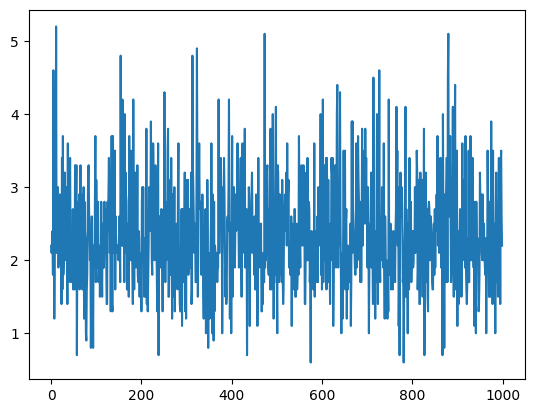

In [18]:
x = [x for x,y in enumerate(random_avg_turns_survived_train_seeds)]
y = [y for x,y in enumerate(random_avg_turns_survived_train_seeds)]
plt.plot(x, y)

### Random on test seeds

In [19]:
rng = random.Random(default_seed)
random_avg_turns_survived_test_seeds: List[int] = perform_random_runs(rng, TEST_SEEDS, 10)
np.average(random_avg_turns_survived_test_seeds)

2.3710999999999993

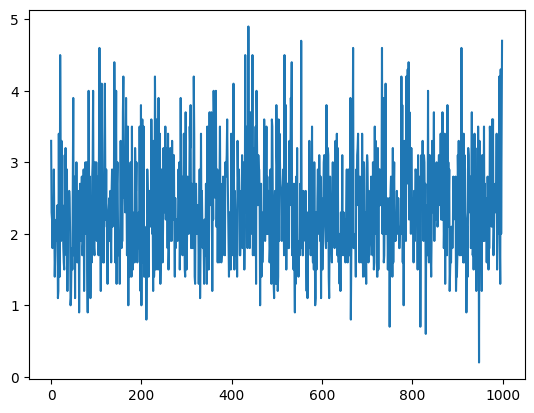

In [20]:
x = [x for x,y in enumerate(random_avg_turns_survived_test_seeds)]
y = [y for x,y in enumerate(random_avg_turns_survived_test_seeds)]
plt.plot(x, y)

In [21]:
import csv
def write_episodes_to_csv(episode_history, file_path):
    with open(file_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow([
            'Episode Number', 
            'Turn Number', 
            'Policy 1', 
            'Policy 2', 
            'Policy 3', 
            'Chosen Policy Number', 
            'Policy Accepted', 
            'Money', 
            'Food', 
            'Reputation', 
            'Pollution', 
            'Oil Power Amount', 
            'Tidal Power Amount'
        ])
        for episode_num, episode in enumerate(episode_history, start=1):
            for turn_num, turn in enumerate(episode, start=1):
                state, action = turn
                policy_1_id, policy_2_id, policy_3_id, stats = state
                money, food, reputation, pollution, oil_amount, tidal_amount = stats.to_tuple()
                chosen_index, policy_accepted = action
                chosen_policy_number = chosen_index + 1
                writer.writerow([
                    episode_num, 
                    turn_num, 
                    get_policy_from_id(policy_1_id).title, 
                    get_policy_from_id(policy_2_id).title, 
                    get_policy_from_id(policy_3_id).title,
                    chosen_policy_number,
                    policy_accepted,
                    money,
                    food,
                    reputation,
                    pollution,
                    oil_amount,
                    tidal_amount
                ])

In [22]:
gamma = 0.99
initial_epsilon = 1.0
epsilon_min = 0.1   
epsilon_decay = 0.998
learning_rate = 0.01

In [23]:
state_shape = example_state_tensor.shape
num_actions = 6
action_shape = tf.convert_to_tensor(list(range(num_actions))).shape
state_shape, action_shape

(TensorShape([1, 48]), TensorShape([6]))

In [24]:
list(range(num_actions))

[0, 1, 2, 3, 4, 5]

In [25]:
env = EcoCity()
env.reset(default_seed)

((5,
  0,
  4,
  EcoCityPlayerStats(money=5000, food=10, reputation=100, pollution=0, oil_power_amount=10, tidal_power_amount=3)),
 {})

In [26]:
def parse_action(action_num: int) -> Tuple[int, bool]:

    mapping = {
        0: (0, True),
        1: (0, False),
        2: (1, True),
        3: (1, False),
        4: (2, True),
        5: (2, False)
    }

    return mapping[action_num]

In [27]:
state_size = example_state_tensor.shape[1]
action_size = num_actions
state_size, action_size

(48, 6)

In [28]:
env = EcoCity()
rng = random.Random(default_seed)
next_state_raw, _ = env.reset(default_seed)
state_tensor = state_to_tensor(next_state_raw)
action = rng.randrange(action_size)
action

5

In [29]:
class EcoCityPlayerAgent:

    state_size: int
    action_size: int
    memory: deque
    gamma: float
    epsilon: float
    epsilon_decay: float
    epsilon_min: float
    learning_rate: float
    seed: int
    rand: random.Random

    def __init__(self, state_size, action_size, gamma, epsilon, epsilon_decay, epsilon_min, learning_rate, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.learning_rate = learning_rate
        self.seed = seed
        self.rand = random.Random(self.seed)
        self.model = self._build_model()
 
    def _build_model(self):
        init = tf.keras.initializers.HeUniform(seed=self.seed)
        model = keras.Sequential(
             [
                  layers.Dense(32, input_shape=(self.state_size,), activation="relu", kernel_initializer=init, name="hidden1"),
                  layers.Dense(32, activation="relu", kernel_initializer=init, name="hidden2"),
                  layers.Dense(self.action_size, activation='linear', kernel_initializer=init, name="output"),
             ]
        )
        model.compile(loss=keras.losses.Huber(), optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model
 
    def remember(self, state, action, reward, next_state, done) -> None: 
        self.memory.append((state, action, reward, next_state, done))

    def train(self, batch_size) -> None:
        minibatch = self.rand.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            # if this is the final state, then we know the Q-value i.e. maximum reward that could be gained from taking the given action
            # if it's not the final state, then we estimate the Q-values starting from the next state
            # we now have a target value that is an estimation of the Q-values for taking the given action
            target = reward if done else (reward + self.gamma * np.amax(self.model(next_state)[0]))
            # we now want to adjust the model parameters against this target
            target_output = tf.Variable(self.model(state)[0].numpy())
            # the target only tells us the reward for this particular action in this memory
            target_output[action].assign(target) 
            self.model.fit(state, tf.expand_dims(target_output, 0), epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def act(self, state) -> int:
        explore_instead_of_exploit = self.rand.random() <= self.epsilon
        action = self.rand.randrange(action_size) \
            if explore_instead_of_exploit \
            else np.argmax(self.model(state)[0])
        return action

In [30]:
agent = EcoCityPlayerAgent(
    state_size,
    action_size,
    gamma,
    initial_epsilon,
    epsilon_decay,
    epsilon_min,
    learning_rate,
    default_seed
)
agent.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1 (Dense)             (None, 32)                1568      
                                                                 
 hidden2 (Dense)             (None, 32)                1056      
                                                                 
 output (Dense)              (None, 6)                 198       
                                                                 
Total params: 2,822
Trainable params: 2,822
Non-trainable params: 0
_________________________________________________________________


In [28]:
batch_size = 10
env = EcoCity()
keras.utils.set_random_seed(default_seed)
training_episode_history = []
for episode_num, train_seed in enumerate(TRAIN_SEEDS, 1):
    game_history = []
    next_state_raw, _ = env.reset(train_seed)
    state_tensor = state_to_tensor(next_state_raw)
    turns_survived = 0
    while True:
        action = agent.act(state_tensor)
        action_parsed = parse_action(action)
        game_history.append((next_state_raw, action_parsed))
        next_state_raw, reward, done, _, _ = env.step(action_parsed)
        next_state_tensor = state_to_tensor(next_state_raw)
        agent.remember(state_tensor, action, reward, next_state_tensor, done)
        state_tensor = next_state_tensor
        if done:
            game_history.append((next_state_raw, (-1, False)))
            print("episode: {}/{}, turns_survived: {}, e: {:.2}"
                  .format(episode_num, len(TRAIN_SEEDS), turns_survived, agent.epsilon))
            training_episode_history.append(game_history)
            break
        turns_survived += 1
    if len(agent.memory) > batch_size:
        agent.train(batch_size)
    if episode_num % 100 == 0:
        agent.model.save_weights(f"/tf/out/model_weights_{episode_num}/")

episode: 1/1000, turns_survived: 1, e: 1.0
episode: 2/1000, turns_survived: 3, e: 1.0
episode: 3/1000, turns_survived: 1, e: 1.0
episode: 4/1000, turns_survived: 1, e: 1.0
episode: 5/1000, turns_survived: 4, e: 1.0


2023-06-14 14:31:20.853974: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-14 14:31:21.610070: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f96ec181990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-14 14:31:21.610095: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-06-14 14:31:21.613278: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-14 14:31:21.728891: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-14 14:31:21.821859: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifeti

episode: 6/1000, turns_survived: 6, e: 1.0
episode: 7/1000, turns_survived: 1, e: 1.0
episode: 8/1000, turns_survived: 7, e: 0.99
episode: 9/1000, turns_survived: 0, e: 0.99
episode: 10/1000, turns_survived: 1, e: 0.99
episode: 11/1000, turns_survived: 15, e: 0.99
episode: 12/1000, turns_survived: 1, e: 0.99
episode: 13/1000, turns_survived: 4, e: 0.98
episode: 14/1000, turns_survived: 4, e: 0.98
episode: 15/1000, turns_survived: 3, e: 0.98
episode: 16/1000, turns_survived: 4, e: 0.98
episode: 17/1000, turns_survived: 1, e: 0.98
episode: 18/1000, turns_survived: 1, e: 0.97
episode: 19/1000, turns_survived: 2, e: 0.97
episode: 20/1000, turns_survived: 3, e: 0.97
episode: 21/1000, turns_survived: 11, e: 0.97
episode: 22/1000, turns_survived: 1, e: 0.97
episode: 23/1000, turns_survived: 4, e: 0.96
episode: 24/1000, turns_survived: 1, e: 0.96
episode: 25/1000, turns_survived: 3, e: 0.96
episode: 26/1000, turns_survived: 1, e: 0.96
episode: 27/1000, turns_survived: 2, e: 0.96
episode: 28/10

In [29]:
write_episodes_to_csv(training_episode_history, "/tf/out/history/episode_history_model_training.csv")

In [30]:
agent.epsilon = 0

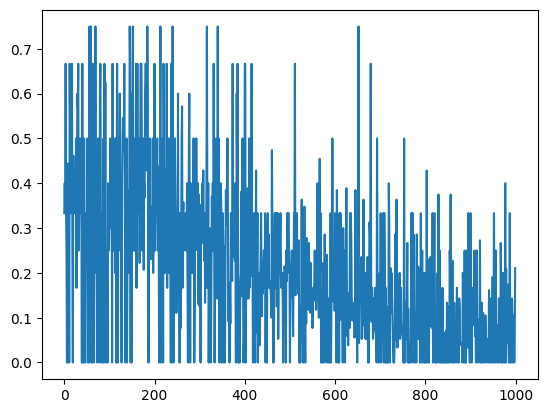

In [42]:
portion_denied = [len([(state, action) for state, action in episode if action[1] == False and action[0] != -1])/len(episode) for episode in training_episode_history]
x = [x for x, y in enumerate(portion_denied)]
y = [y for x, y in enumerate(portion_denied)]
plt.plot(x, y)

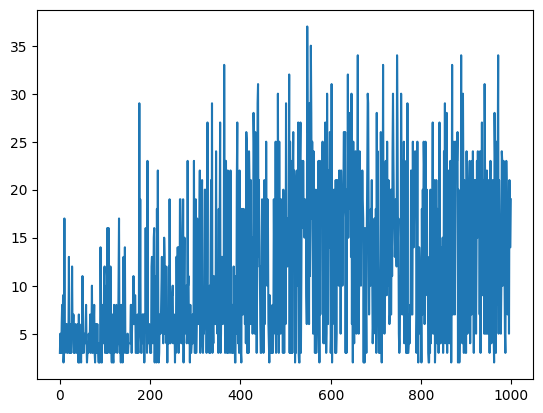

In [32]:
episode_length = [len(episode) for episode in training_episode_history]
x = [x for x, y in enumerate(episode_length)]
y = [y for x, y in enumerate(episode_length)]
plt.plot(x, y)

In [33]:
agent.model.load_weights("/tf/out/model_weights_1000/")

In [34]:
model_episode_history_train_seeds = []
for train_seed in TRAIN_SEEDS:
    game = EcoCity()
    state, _ = game.reset(train_seed)
    game_history = []
    turns_survived = 0
    while True:
        policy_a, policy_b, policy_c, stats = state
        agent.epsilon = -1
        action = agent.act(state_to_tensor(state))
        action_parsed = parse_action(action)
        chosen_index, accept = action_parsed
        game_history.append((state, action_parsed))
        state, reward, done, _, _ = game.step(action_parsed)
        if done:
            game_history.append((state, (-1, False)))
            print(f"Train seed {train_seed} survived {turns_survived} turns")
            break
        turns_survived += 1
    model_episode_history_train_seeds.append(game_history)

2023-06-16 10:07:07.799384: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Train seed 0 survived 22 turns
Train seed 1 survived 21 turns
Train seed 2 survived 3 turns
Train seed 3 survived 15 turns
Train seed 4 survived 4 turns
Train seed 5 survived 20 turns
Train seed 6 survived 14 turns
Train seed 7 survived 22 turns
Train seed 8 survived 0 turns
Train seed 9 survived 20 turns
Train seed 10 survived 17 turns
Train seed 11 survived 28 turns
Train seed 12 survived 25 turns
Train seed 13 survived 27 turns
Train seed 14 survived 15 turns
Train seed 15 survived 18 turns
Train seed 16 survived 24 turns
Train seed 17 survived 20 turns
Train seed 18 survived 5 turns
Train seed 19 survived 3 turns
Train seed 20 survived 26 turns
Train seed 21 survived 16 turns
Train seed 22 survived 16 turns
Train seed 23 survived 20 turns
Train seed 24 survived 17 turns
Train seed 25 survived 32 turns
Train seed 26 survived 3 turns
Train seed 27 survived 24 turns
Train seed 28 survived 29 turns
Train seed 29 survived 16 turns
Train seed 30 survived 15 turns
Train seed 31 survived 5

19.044


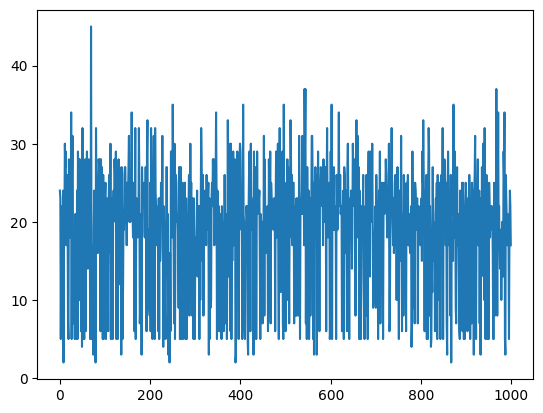

In [35]:
rng = random.Random(default_seed)
model_turns_survived_train_seeds: List[int] = [len(episode) for episode in model_episode_history_train_seeds]
print(np.average(model_turns_survived_train_seeds))
x = [x for x,y in enumerate(model_turns_survived_train_seeds)]
y = [y for x,y in enumerate(model_turns_survived_train_seeds)]
plt.plot(x, y)

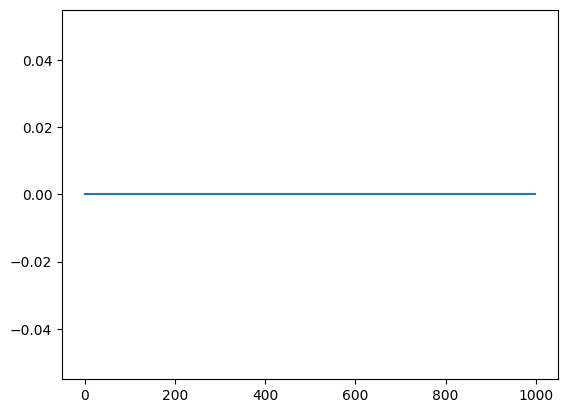

In [36]:
portion_denied = [len([(state, action) for state, action in episode if action[1] == False and action[0] != -1])/len(episode) for episode in model_episode_history_train_seeds]
x = [x for x, y in enumerate(portion_denied)]
y = [y for x, y in enumerate(portion_denied)]
plt.plot(x, y)

In [37]:
model_episode_history_test_seeds = []
for train_seed in TEST_SEEDS:
    game = EcoCity()
    state, _ = game.reset(train_seed)
    game_history = []
    turns_survived = 0
    while True:
        policy_a, policy_b, policy_c, stats = state
        agent.epsilon = -1
        action = agent.act(state_to_tensor(state))
        action_parsed = parse_action(action)
        chosen_index, accept = action_parsed
        game_history.append((state, action_parsed))
        state, reward, done, _, _ = game.step(action_parsed)
        if done:
            game_history.append((state, (-1, False)))
            print(f"Test seed {train_seed} survived {turns_survived} turns")
            break
        turns_survived += 1
    model_episode_history_test_seeds.append(game_history)

Test seed 1000 survived 6 turns
Test seed 1001 survived 23 turns
Test seed 1002 survived 31 turns
Test seed 1003 survived 21 turns
Test seed 1004 survived 21 turns
Test seed 1005 survived 16 turns
Test seed 1006 survived 16 turns
Test seed 1007 survived 25 turns
Test seed 1008 survived 24 turns
Test seed 1009 survived 20 turns
Test seed 1010 survived 7 turns
Test seed 1011 survived 6 turns
Test seed 1012 survived 3 turns
Test seed 1013 survived 21 turns
Test seed 1014 survived 23 turns
Test seed 1015 survived 25 turns
Test seed 1016 survived 24 turns
Test seed 1017 survived 20 turns
Test seed 1018 survived 19 turns
Test seed 1019 survived 23 turns
Test seed 1020 survived 16 turns
Test seed 1021 survived 21 turns
Test seed 1022 survived 11 turns
Test seed 1023 survived 16 turns
Test seed 1024 survived 18 turns
Test seed 1025 survived 17 turns
Test seed 1026 survived 15 turns
Test seed 1027 survived 22 turns
Test seed 1028 survived 5 turns
Test seed 1029 survived 19 turns
Test seed 1030 

18.819
42


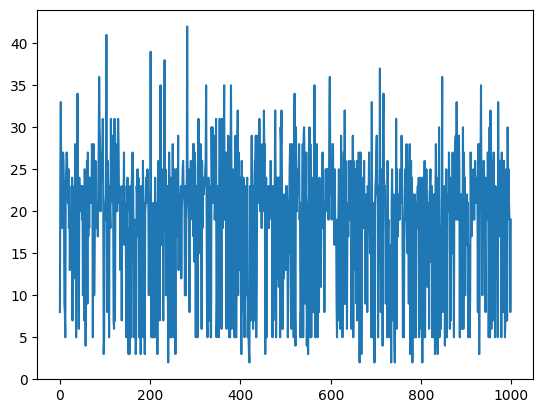

In [38]:
model_turns_survived_test_seeds: List[int] = [len(episode) for episode in model_episode_history_test_seeds]
print(np.average(model_turns_survived_test_seeds))
print(np.max(model_turns_survived_test_seeds))
x = [x for x,y in enumerate(model_turns_survived_test_seeds)]
y = [y for x,y in enumerate(model_turns_survived_test_seeds)]
plt.plot(x, y)

In [39]:
lists = [[1], [2]]
sum(lists, [])

[1, 2]

<BarContainer object of 6 artists>

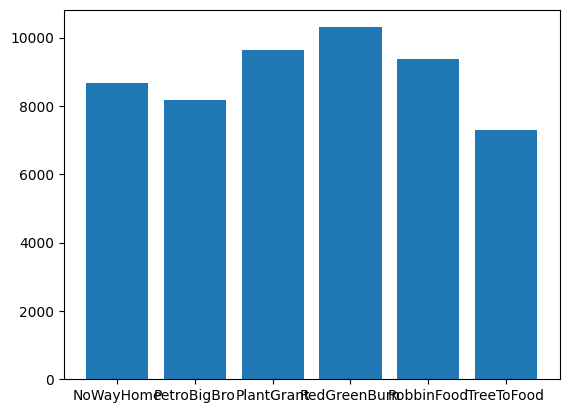

In [40]:
titles = sum([sum([
    [(get_policy_from_id(a).title), (get_policy_from_id(b).title), get_policy_from_id(c).title] 
        for (a, b, c, _), action 
        in episode 
        if action[0] != -1
    ], [])
    for episode 
    in model_episode_history_test_seeds
], [])
x, y = np.unique(titles, return_counts=True)
plt.bar(x, y)

In [41]:
acceptance_rate = [[
    (get_policy_from_id(policy_id).title, accepted)
        for (a, b, c, _), (policy_id, accepted)
        in episode 
        if policy_id != -1
    ]
    for episode 
    in model_episode_history_test_seeds
]
acceptance_rate

[[('RedGreenBurn', True),
  ('RedGreenBurn', True),
  ('PetroBigBro', True),
  ('RedGreenBurn', True),
  ('RedGreenBurn', True),
  ('PetroBigBro', True),
  ('RedGreenBurn', True)],
 [('PetroBigBro', True),
  ('RedGreenBurn', True),
  ('RedGreenBurn', True),
  ('RedGreenBurn', True),
  ('PetroBigBro', True),
  ('RedGreenBurn', True),
  ('RedGreenBurn', True),
  ('PetroBigBro', True),
  ('RedGreenBurn', True),
  ('PetroBigBro', True),
  ('PetroBigBro', True),
  ('RedGreenBurn', True),
  ('PetroBigBro', True),
  ('PetroBigBro', True),
  ('RedGreenBurn', True),
  ('PetroBigBro', True),
  ('RedGreenBurn', True),
  ('PetroBigBro', True),
  ('RedGreenBurn', True),
  ('PetroBigBro', True),
  ('RedGreenBurn', True),
  ('RedGreenBurn', True),
  ('RedGreenBurn', True),
  ('RedGreenBurn', True)],
 [('PetroBigBro', True),
  ('PetroBigBro', True),
  ('PetroBigBro', True),
  ('RedGreenBurn', True),
  ('RedGreenBurn', True),
  ('RedGreenBurn', True),
  ('PetroBigBro', True),
  ('RedGreenBurn', True),


In [42]:
write_episodes_to_csv(model_episode_history_train_seeds, "/tf/out/history/episode_history_model_train.csv")
write_episodes_to_csv(model_episode_history_test_seeds, "/tf/out/history/episode_history_model_test.csv")